# Real Data Seismogram Simulation
For this simulation, we will utilize real earthquake data that we obtain from the USGS library and the Vp, Vs, and Density model from the IASP91 and CRUST 1.0 library. 

IASP91 is a standard ID Earth velocity model, where it describes average Vp and Vs based on the depth of the Earth. It assumes that Earth's Vp and Vs only vary within depth, not with the location.

Meanwhile, CRUST 1.0 is a model files that can be used to obtain more realistic crustal velocity and density model based on the latitude and longitude (location specific). But, it is more accurate only until ~50 km of the crustal structure. So, we decided to combine IASP91 with CRUST1.0 for better visualization purpose.

In [49]:
from libcomcat.dataframes import (get_detail_data_frame, get_dyfi_data_frame,
                                  get_history_data_frame, get_magnitude_data_frame,
                                  get_pager_data_frame, get_phase_dataframe,
                                  get_summary_data_frame)
from libcomcat.search import search, get_event_by_id
from datetime import datetime
import netCDF4 as nc
import numpy as np
from obspy.taup import TauPyModel
import matplotlib.pyplot as plt

In [50]:
# Get summary of earthquake events based on the USGS library
summary_events = search(starttime=datetime(1994, 1, 17, 12, 30), endtime=datetime(1994, 1, 17, 12, 35),
    )
summary_df = get_summary_data_frame(summary_events)
summary_df

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,ci3144585,1994-01-17 12:30:55.390000+00:00,"Northridge, California, earthquake",34.213,-118.537,18.202,6.70,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1561
1,ci3145042,1994-01-17 12:30:55.850000+00:00,"1km NW of Northridge, California",34.240,-118.541,20.322,3.55,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,194
2,ci3149646,1994-01-17 12:31:58.120000+00:00,"1km ENE of Granada Hills, California",34.275,-118.493,5.317,5.89,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,534
3,ci3144587,1994-01-17 12:32:54.530000+00:00,"7km S of Santa Clarita, California",34.351,-118.500,9.317,3.27,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,165
4,ci2153163,1994-01-17 12:33:50.830000+00:00,"6km SE of Santa Clarita, California",34.377,-118.467,5.285,3.56,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,195
5,ci3144599,1994-01-17 12:34:18.420000+00:00,"4km NW of Pacoima, California",34.308,-118.475,5.487,4.44,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,303


In [51]:
# The CRUST1.0 model
vp_dataset = nc.Dataset('CRUST1.0-vp.r0.1.nc')
vs_dataset = nc.Dataset('CRUST1.0-vs.r0.1.nc')
rho_dataset = nc.Dataset('CRUST1.0-rho.r0.1.nc')

# location
choice = 0
latitude = summary_df['latitude'][choice]
longitude = summary_df['longitude'][choice]
if longitude < 0:
    longitude += 360

latitudes = vp_dataset.variables['latitude'][:]
longitudes = vp_dataset.variables['longitude'][:]
lat_idx = np.abs(latitudes - latitude).argmin()
lon_idx = np.abs(longitudes - longitude).argmin()

In [52]:
# layers and average thickness
layers = [
    ("water_vp", "water_vs", "water_rho", 3000),
    ("ice_vp", "ice_vs", "ice_rho", 2000),
    ("upper_sediments_vp", "upper_sediments_vs", "upper_sediments_rho", 2000),
    ("middle_sediments_vp", "middle_sediments_vs", "middle_sediments_rho", 3000),
    ("lower_sediments_vp", "lower_sediments_vs", "lower_sediments_rho", 5000),
    ("upper_crust_vp", "upper_crust_vs", "upper_crust_rho", 10000),
    ("middle_crust_vp", "middle_crust_vs", "middle_crust_rho", 15000),
    ("lower_crust_vp", "lower_crust_vs", "lower_crust_rho", 20000)
]

In [53]:
crust_depths = []
crust_vp = []
crust_vs = []
crust_rho = []

depth = 0  
for vp_layer, vs_layer, rho_layer, thickness in layers:
    vp = vp_dataset.variables.get(vp_layer, None)
    vs = vs_dataset.variables.get(vs_layer, None)
    rho = rho_dataset.variables.get(rho_layer, None)

    # convert to m/s for vp and vs and to kg/m^3 for rho
    vp_val = float(vp[lat_idx, lon_idx]) * 1000 if vp is not None else np.nan
    vs_val = float(vs[lat_idx, lon_idx]) * 1000 if vs is not None else np.nan
    rho_val = float(rho[lat_idx, lon_idx]) * 1000 if rho is not None else np.nan

    crust_depths.append(depth)
    crust_vp.append(vp_val)
    crust_vs.append(vs_val)
    crust_rho.append(rho_val)

    depth += thickness

crust_depths = np.array(crust_depths)
crust_vp = np.array(crust_vp)
crust_vs = np.array(crust_vs)
crust_rho = np.array(crust_rho)

### The Gardner's Equation
The Gardner's Equation is a derived equation that relates the seismic P-wave velocity (Vp) with the density of the medium which the wave travels. The equation is as below.
$$
\rho = \alpha V_p^{\beta}
$$
where $\rho$ is the density in $g/cm^3$, $\alpha$ and $\beta$ are constants that depends on the geology. Gardner et al. proposed that a good fit can be obtained if we use $\alpha = 0.31$ and $\beta = 0.25$ if $V_p$ in $m/s$.

In [54]:
# The IASP91 model
model = TauPyModel("iasp91")
iasp_depths = []
iasp_vp = []
iasp_vs = []
iasp_rho = []  

for layer in model.model.s_mod.v_mod.layers:
    d = layer[0] * 1000
    if d <= crust_depths[-1]:
        continue  # skip shallow layers

    iasp_depths.append(d)
    iasp_vp.append(layer[2] * 1000)
    iasp_vs.append(layer[3] * 1000)

    # Rough density estimate via Gardner's Equation
    rho_est = 0.31 * ((layer[2] * 1000) ** (0.25))  
    iasp_rho.append(rho_est * 1000)

iasp_depths = np.array(iasp_depths)
iasp_vp = np.array(iasp_vp)
iasp_vs = np.array(iasp_vs)
iasp_rho = np.array(iasp_rho)

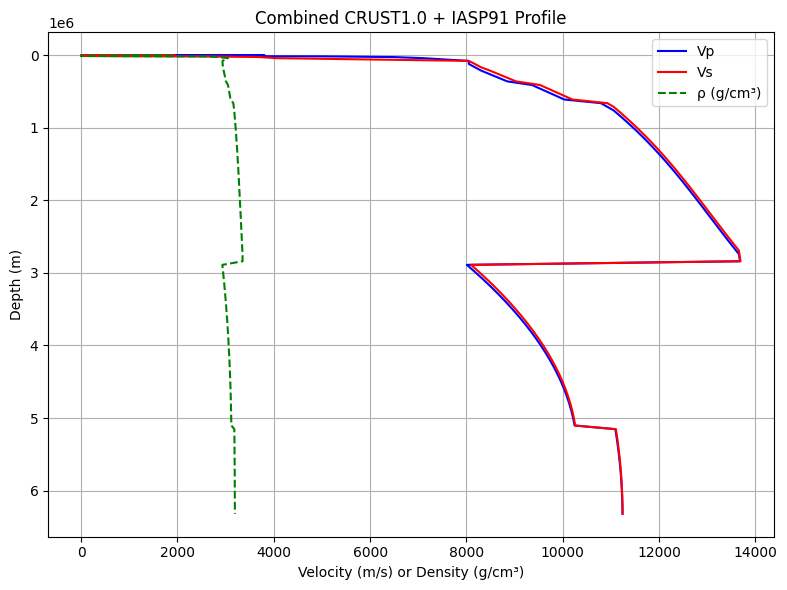

In [55]:
depth_combined = np.concatenate([crust_depths, iasp_depths])
vp_combined = np.concatenate([crust_vp, iasp_vp])
vs_combined = np.concatenate([crust_vs, iasp_vs])
rho_combined = np.concatenate([crust_rho, iasp_rho])

# -----------------------------
# 4. Plot result
# -----------------------------
plt.figure(figsize=(8, 6))
plt.plot(vp_combined, depth_combined, label='Vp', color='blue')
plt.plot(vs_combined, depth_combined, label='Vs', color='red')
plt.plot(rho_combined, depth_combined, label='ρ (g/cm³)', color='green', linestyle='--')

plt.gca().invert_yaxis()
plt.xlabel('Velocity (m/s) or Density (g/cm³)')
plt.ylabel('Depth (m)')
plt.title('Combined CRUST1.0 + IASP91 Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# calculate x and y based on latitude and longitude
from geopy.distance import geodesic
from math import cos

NX, NY = 200, 400
XMIN, XMAX = 0.0, 2000.0
YMIN, YMAX = 0.0, 4000.0
DX = (XMAX - XMIN) / NX
DY = (YMAX - YMIN) / NY

# 1 degree latitude ≈ 111 km (constant)
# 1 degree longitude ≈ 111 km × cos(latitude)
epicenter = (latitude, longitude)
deg_per_meter_lat = 1 / 111000 
deg_per_meter_lon = 1 / (111000 * cos(latitude)) 
origin_lat = epicenter[0] - (YMAX / 2) * deg_per_meter_lat
origin_lon = epicenter[1]- (XMAX / 2) * deg_per_meter_lon

y_meters = geodesic((origin_lat, origin_lon), (epicenter[0], origin_lon)).meters
x_meters = geodesic((origin_lat, origin_lon), (origin_lat, epicenter[1])).meters

# Convert to grid index
source_y = int(y_meters / DY)
source_x = int(x_meters / DX)
print(f'source_x: {source_x}, source_y: {source_y}')


source_x: 88, source_y: 199


In [58]:
# --- Velocity Model ---
from scipy.interpolate import interp1d

# Interpolate real velocity and density data to match NY grid size
depth_target = np.linspace(0, YMAX, NY)  # in meters

vp_interp = interp1d(depth_combined, vp_combined, bounds_error=False, fill_value="extrapolate")
vs_interp = interp1d(depth_combined, vs_combined, bounds_error=False, fill_value="extrapolate")
rho_interp = interp1d(depth_combined, rho_combined, bounds_error=False, fill_value="extrapolate")

vp_profile = vp_interp(depth_target)
vs_profile = vs_interp(depth_target)
rho_profile = rho_interp(depth_target)

# Assign to full grid
VEL_P = np.tile(vp_profile, (NX, 1))
VEL_S = np.tile(vs_profile, (NX, 1))
RHO = np.tile(rho_profile, (NX, 1))

vp_profile = VEL_P[source_x, :]
vs_profile = VEL_S[source_x, :]
rho_profile = RHO[source_x, :]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
# Animation Plot Parameter
PLOT_EVERY = 5  
DT = 0.001  # Time step (s)
NT = 900  

# Wave speed model (m/s) - Simple one layer model
VEL = VEL_P  # Base velocity (rock)

# Wave speed model (m/s) - Simple two-layer model
# VEL = np.ones((NX, NY)) * 3000.0  # Base velocity (water)
# VEL[NX//2:, :] = 3000.0  # Higher velocity layer (rock)

# Density model (kg/m³)
# For real world Earth structure, this is not supposed to be 
# constant because the Earth is not homogeneous or 
# anisotropic (properties vary based on direction)
phi = np.zeros((NX, NY))  # Pressure field (current)
psi = np.zeros((NX, NY))  # Pressure field (previous)
vx = np.zeros((NX, NY))  # x-component of particle velocity
vy = np.zeros((NX, NY))  # y-component of particle velocity

# Damping or Absorbing Boundary
ABL_WIDTH = 20 #grid point on simulation area's edge for absorbing
damping = np.ones((NX, NY)) 

# pressure on top and bottom get scaled down from 1.0 to 0.9
damping[:ABL_WIDTH, :] = np.linspace(0.9, 1.0, ABL_WIDTH)[:, np.newaxis]
damping[-ABL_WIDTH:, :] = np.linspace(1.0, 0.9, ABL_WIDTH)[:, np.newaxis]

# preserve the strongest damping when overlapping in left and right edge
damping[:, :ABL_WIDTH] = np.minimum(damping[:, :ABL_WIDTH], np.linspace(0.9, 1.0, ABL_WIDTH))
damping[:, -ABL_WIDTH:] = np.minimum(damping[:, -ABL_WIDTH:], np.linspace(1.0, 0.9, ABL_WIDTH))

# Seismic source (Ricker wavelet at center)
def ricker_wavelet(t, f0=20.0):
    return (1.0 - 2.0*(np.pi*f0*t)**2) * np.exp(-(np.pi*f0*t)**2)

source_times = np.arange(NT) * DT # Time values

# Pressure amplitude
# The peak will occur on t which is source_times-0.1 or in
# 0.1 seconds instead right at t=0, so that it is smoother
source_amp = ricker_wavelet(source_times - 0.1, f0=20.0) * 1e6  
def update_wave(n):
    """Update the wave field for one time step"""
    global phi, psi, vx, vy
    
    # Add pressure injection/amplitude (S) to pressure field
    if n < len(source_amp):
        phi[source_x, source_y] += source_amp[n]
    
    # Update particle velocities (vx, vy)
    # vx[1:-1, 1:-1] -= (DT/RHO[1:-1, 1:-1]) * (phi[2:, 1:-1] - phi[:-2, 1:-1]) / (2*DX)
    # vy[1:-1, 1:-1] -= (DT/RHO[1:-1, 1:-1]) * (phi[1:-1, 2:] - phi[1:-1, :-2]) / (2*DX)
    
    # Update pressure field based on the final p_{i,j}^{n+1} formula
    phi_new = phi.copy()
    phi_new[1:-1, 1:-1] = (
        2*phi[1:-1, 1:-1] - psi[1:-1, 1:-1] +
        (VEL[1:-1, 1:-1]**2 * DT**2 / DX**2) * (
            
            phi[2:, 1:-1] + phi[:-2, 1:-1] +
            phi[1:-1, 2:] + phi[1:-1, :-2] -
            4*phi[1:-1, 1:-1]
        )
    )
    # apply damping
    phi_new *= damping

    # Update fields
    psi = phi.copy()
    phi = phi_new.copy()


# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
img = ax.imshow(phi.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                cmap='seismic', vmin=-1e4, vmax=1e4)
plt.colorbar(img, label='Pressure (Pa)')
ax.set_title("2D Seismic Wave Propagation")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")

plt.show()

def update(frame):
    """Update function for animation"""
    for _ in range(PLOT_EVERY):
        update_wave(frame * PLOT_EVERY + _)
    
    img.set_array(phi.T)
    return [img]

ani = FuncAnimation(fig, update, frames=NT//PLOT_EVERY, interval=50, blit=True)

ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani.save('test_data_wave2.mp4', writer=ffmpeg_writer)

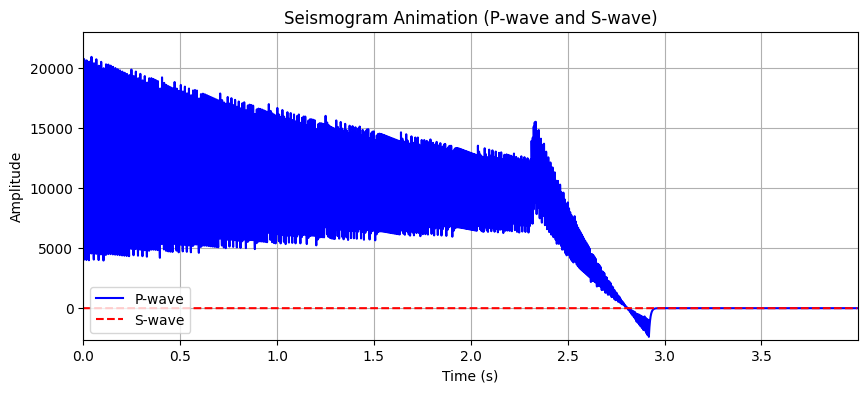

In [ ]:
# TESTINGG
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# --- Grid Parameters ---
DT = 0.001
t_max = 4.0
time = np.arange(0, t_max, DT)
NT = len(time)

# Animation config
PLOT_EVERY = 5  # Plot every 5 time steps
frames = len(time) // PLOT_EVERY

def compute_reflection_coeffs(vel_profile, rho_profile):
    rc = []
    for i in range(len(vel_profile) - 1):
        # Skip if either current or next layer has Vs=0 (air/water)
        if vel_profile[i] == 0 or vel_profile[i+1] == 0:
            rc.append(0)  # No reflection
            continue
            
        z1 = rho_profile[i] * vel_profile[i]
        z2 = rho_profile[i+1] * vel_profile[i+1]
        r = (z2 - z1) / (z2 + z1)
        rc.append(r)
    return np.array(rc)

rc_p = compute_reflection_coeffs(vp_profile, rho_profile)
rc_s = compute_reflection_coeffs(vs_profile, rho_profile)

def compute_twt(vel_profile, dy):
    twt = [0.0]
    for i in range(1, len(vel_profile)):
        if vel_profile[i] == 0:  # Skip S-wave in air/water
            twt.append(np.inf)   # Infinite travel time (never arrives)
            continue
        avg_v = (vel_profile[i-1] + vel_profile[i]) / 2
        dt_depth = 2 * dy / avg_v
        twt.append(twt[-1] + dt_depth)
    return np.array(twt)

twt_p = compute_twt(vp_profile, DX)
twt_s = compute_twt(vs_profile, DX)

def create_reflectivity_series(rc, twt, time, dt):
    series = np.zeros_like(time)
    for i, t in enumerate(twt[:-1]):
        if np.isinf(t):  # Skip if travel time is infinite
            continue
        idx = int(t / dt)
        if 0 <= idx < len(series):
            series[idx] = rc[i]
    return series

reflectivity_p = create_reflectivity_series(rc_p, twt_p, time, DT)
reflectivity_s = create_reflectivity_series(rc_s, twt_s, time, DT)

# --- Ricker Wavelet ---    
# Used to simulate the source wavelet
def ricker_wavelet(t, f0=20.0):
    return (1.0 - 2.0*(np.pi*f0*t)*2) * np.exp(-(np.pi*f0*t)*2)

f0_p = 20.0
f0_s = 15.0
t_wavelet = np.linspace(-0.1, 0.1, int(0.2 / DT))
wavelet_p = ricker_wavelet(t_wavelet, f0_p)
wavelet_s = ricker_wavelet(t_wavelet, f0_s)

# --- Create Seismograms ---
seismogram_p = np.convolve(reflectivity_p, wavelet_p, mode='same')
seismogram_s = np.convolve(reflectivity_s, wavelet_s, mode='same')
seismogram_s *= 1.5  # Amplify S-wave
seismogram_s = np.roll(seismogram_s, int(0.2 / DT))  # Phase shift

combined_seismogram = seismogram_p + seismogram_s
# --- Animation for seismogram with separated P and S wave ---
fig, ax = plt.subplots(figsize=(10, 4))
line_p, = ax.plot([], [], color='blue', label='P-wave')
line_s, = ax.plot([], [], color='red', label='S-wave', linestyle='--')

ax.set_xlim(0, time[-1])
min_val = min(seismogram_p.min(), seismogram_s.min()) * 1.1
max_val = max(seismogram_p.max(), seismogram_s.max()) * 1.1
ax.set_ylim(min_val, max_val)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Seismogram Animation (P-wave and S-wave)')
ax.grid(True)
ax.legend(loc='lower left')

def init():
    line_p.set_data([], [])
    line_s.set_data([], [])
    return line_p, line_s

def update(frame):
    idx = min(frame * PLOT_EVERY, len(time) - 1)
    line_p.set_data(time[:idx], seismogram_p[:idx])
    line_s.set_data(time[:idx], seismogram_s[:idx])
    return line_p, line_s

ani = FuncAnimation(fig, update, frames=frames, init_func=init, interval=20, blit=True)
ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani.save('testing_realdata.mp4', writer=ffmpeg_writer)